In [1]:
from sklearn import datasets, tree, metrics, ensemble
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time
from sklearn.model_selection import train_test_split
import pandas as pd
import statistics
import einops

In [2]:
samples = 2428
seed = 244828
time_multiplicator = 1

In [3]:
def normalize(matrix):
    return (matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))

def standarize(matrix):
    return (matrix - np.mean(matrix))/(np.std(matrix))

In [4]:
def visualization(my,X_tr, X_te, y_tr, y_te, name, roc=True):
    my_time = time.perf_counter()
    for i in range(time_multiplicator):
        my.use(mse, mse_prime)
        my.fit(X_tr,y_tr, epochs=20, learning_rate=0.1)
    
    my_time = (time.perf_counter() - my_time)/time_multiplicator
    my_pred = my.predict(X_te)
    my_pred = np.round(my_pred).reshape(X_test.shape[0])
    
    #graph
    if roc:
        fig, axs = plt.subplots(3, 1,figsize=(10,20))
        mesh = np.meshgrid(np.arange(-4.5, 4.5, 0.01), np.arange(-4.5, 4.5, 0.01))[0]
    else:
#         my_pred = np.round(my_pred)
        fig, axs = plt.subplots(3, 1,figsize=(10,20))
        mesh = np.meshgrid(np.arange(-2, 3, 0.01), np.arange(-2, 3, 0.01))[0]

    my_predict = np.array(my.predict(np.c_[mesh.ravel(), mesh.T.ravel()])).reshape(mesh.shape)
    
    axs[0].set_title(name)
    axs[0].contourf(mesh, mesh.T, my_predict, alpha=0.2)
    axs[0].scatter(X_te[:, 0], X_te[:, 1], c=y_te, marker="o", alpha=0.5)
    axs[0].scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, marker="+", alpha=0.2)
    
    #confusion matrix
#     print(y_test)
#     print(10*'=')
#     print(my_pred)
    my_cm = metrics.confusion_matrix(y_test, my_pred)
    my_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=my_cm)
    my_disp.plot(ax=axs[1])
    my_disp.ax_.set_ylabel('')
    
    #roc
#     if roc:
#         fpr, tpr, thresholds = metrics.roc_curve(y_te, my.predict(X_test))
#         roc_auc = metrics.auc(fpr, tpr)
#         display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Własna')
#         display.plot(ax=axs[2])
        

    fpr, tpr, thresholds = metrics.roc_curve(y_te, my.predict(X_test))
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
    display.plot(ax=axs[2])

    
    my_sens = my_cm[0][0]/(my_cm[0][0]+my_cm[1][0])
    my_spec = my_cm[1][1]/(my_cm[0][0]+my_cm[1][1])
    my_acc = metrics.accuracy_score(my_pred, y_test)
    
    print(f'                  | {name}  ')
    print(f'Czułość           |{my_sens:9.4f}')
    print(f'Swoistość         |{my_spec:9.4f}')
    print(f'Accuracy          |{my_acc:9.4f}')
    print(f'Czas wykonania    |{my_time:9.2E}')

In [5]:

class myNeuron:
    def logisticAct(self, X):
        return 1 / (1 + np.exp(-X))

    def logisticDer(self, X):
        return self.logisticAct(X) * (1-self.logisticAct(X))

    def heavisideAct(self, X):
        return np.havyside(X,0.5)

    def heavisideDer(self, X):
        return np.ones(X.shape[0])
    
    def sinAct(self, X):
        return np.sin(X)

    def sinDer(self, X):
        return np.cos(X)
    
    def tanhAct(self, X):
        return np.tanh(X)

    def tanhDer(self, X):
        return 1 / (np.cosh(X) ** 2)
    
    def signAct(self, X):
        return np.sign(X)

    def signDer(self, X):
        return np.ones_like(X)
    
    def reluAct(self, X):
        return np.where(X > 0, X, 0)

    def reluDer(self, X):
        return np.where(X > 0, 1, 0)
    
    def leakyReluAct(self, X):
        return np.where(X >= 0, X, 0.01 * X)

    def leakyReluDer(self, X):
        return np.where(X >= 0, 1, 0.01)
    
    def activationFunction(self, activation):
        activationFunctionDic = {'logistic':[self.logisticAct,self.logisticDer, 0.5],
                                 'heaviside':[self.logisticAct,self.logisticDer, 0],
                                 'sin':[self.sinAct,self.sinDer,0],
                                 'tanh':[self.tanhAct,self.tanhDer,0],
                                 'sign':[self.signAct,self.signDer,0], 
                                 'relu':[self.reluAct,self.reluDer,0], 
                                 'leakyRelu':[self.leakyReluAct,self.leakyReluDer,0.01]}
        
        return activationFunctionDic[activation][0], activationFunctionDic[activation][1], activationFunctionDic[activation][2]

        
        
    def __init__(self, input_size=2,activation='logistic', batch=8):
        self.rng = np.random.default_rng()
        self.w = self.rng.random(input_size+1)
        self.batch_size = batch
        self.activation, self.derivative, self.threshold = self.activationFunction(activation)
        
#         if activation=='logistic':
#             self.threshold = 0.5
#             self.activation = self.logisticAct
#             self.derivative = self.logisticDer
            
            
    def expand_features(self, X):
        batch_size = X.shape[0]
        return np.c_[X, np.ones(batch_size)* -1.0]
    
    def fit(self, X, y,eta=0.01, epochs=50):
        samples = X.shape[0]
        batch_divisible = samples - (samples % self.batch_size)
        indexes = np.arange(samples)
        for i in range(epochs):
            np.random.shuffle(indexes)
            X_batched = X[indexes][:batch_divisible]
            y_batched = y[indexes][:batch_divisible]
            
            X_batched = einops.rearrange(X_batched,"(batches size) features -> batches size features",size=self.batch_size)
            y_batched = einops.rearrange(y_batched,"(batches size) -> batches size",size=self.batch_size)

            for X_batch, y_true in zip(X_batched, y_batched):
                
                y_pred = self.predict(X_batch)
                epsilon = y_true - y_pred
                grad = self.derivative(self.transform(X_batch))
                
                epsilon = einops.rearrange(epsilon,"size -> size 1")
                grad = einops.rearrange(grad, "size -> size 1")
                
                delta = eta * epsilon * grad * self.expand_features(X_batch)
                self.w += np.mean(delta, axis=0)
                
    
    def transform(self, X):
        X = self.expand_features(X)
        return X @ self.w
    
    def predict(self, X):
        return np.where(self.activation(self.transform(X)) > self.threshold, 1, 0)
#         return self.activation(self.transform(X))
    

In [6]:
X, y  = datasets.make_classification(
    n_features=2, 
    n_clusters_per_class=1,
    n_redundant=0,
    n_samples=samples, 
    random_state=seed
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_train = normalize(X_train)
# X_test = normalize(X_test)

                  | logistic  
Czułość           |   0.9537
Swoistość         |   0.5187
Accuracy          |   0.8807
Czas wykonania    | 1.72E+00


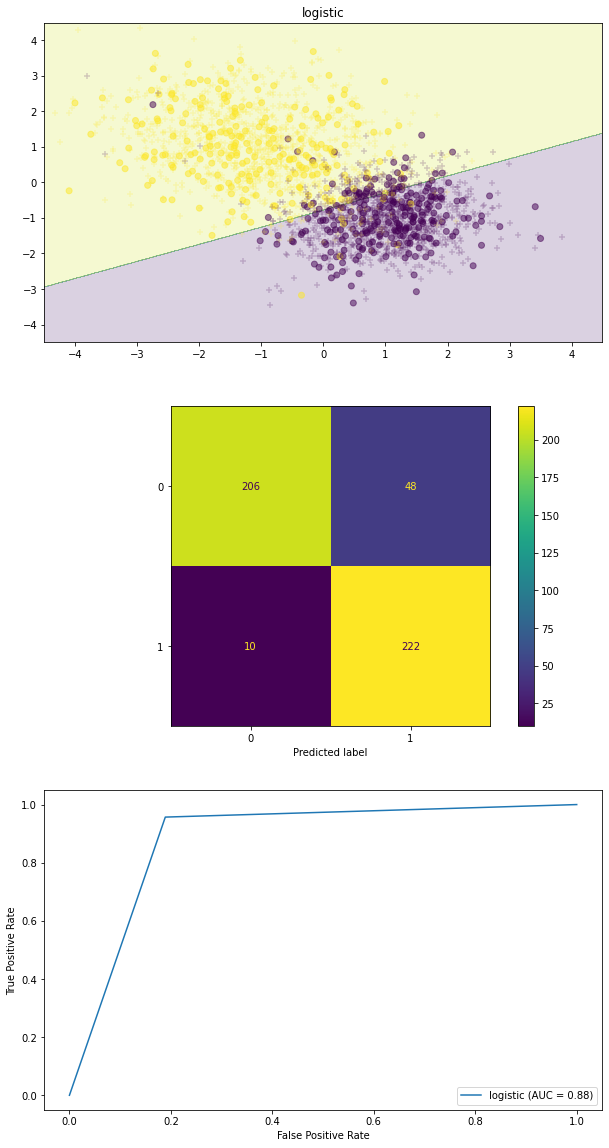

In [7]:
model = myNeuron(activation='logistic')
visualization(model ,X_train, X_test, y_train, y_test, activation='logistic')

                  | logistic  
Czułość           |   0.5215
Swoistość         |   0.5477
Accuracy          |   0.4959
Czas wykonania    | 3.07E+00


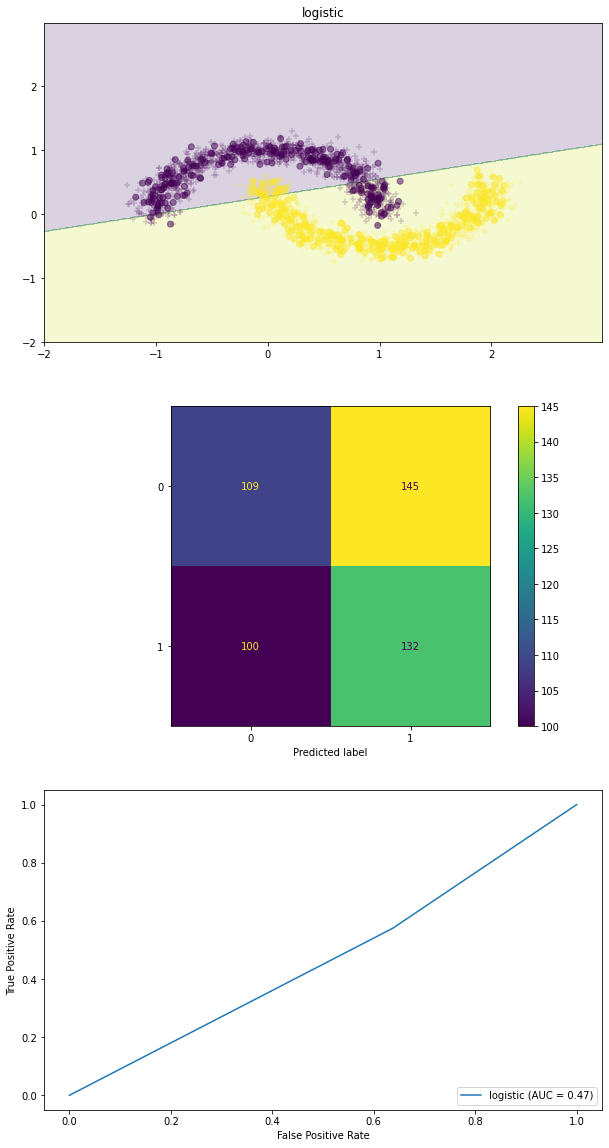

In [8]:
moons, moons_c = datasets.make_moons(n_samples=samples, noise = 0.1, random_state=seed)
M_train, M_test, mc_train, mc_test = train_test_split(moons, moons_c, test_size=0.2, random_state=0)
# M_train = normalize(M_train)
# M_test = normalize(M_test)

moon_model = myNeuron(activation='logistic')
visualization(moon_model, M_train, M_test, mc_train, mc_test, activation='logistic',roc=False)

In [9]:
lst = ['heaviside', 'sin', 'tanh', 'sign', 'relu', 'leakyRelu']

C:\Users\Bartek\AppData\Local\Temp\ipykernel_3852\3666139380.py:49: RuntimeWarning: invalid value encountered in longlong_scalars
  my_sens = my_cm[0][0]/(my_cm[0][0]+my_cm[1][0])


                  | heaviside  
Czułość           |      nan
Swoistość         |   1.0000
Accuracy          |   0.4774
Czas wykonania    | 4.40E+00
                  | sin  
Czułość           |   0.9596
Swoistość         |   0.5103
Accuracy          |   0.8992
Czas wykonania    | 3.83E+00
                  | tanh  
Czułość           |   0.9051
Swoistość         |   0.4537
Accuracy          |   0.9342
Czas wykonania    | 4.04E+00
                  | sign  
Czułość           |   0.9344
Swoistość         |   0.4705
Accuracy          |   0.9403
Czas wykonania    | 4.35E+00
                  | relu  
Czułość           |   0.5370
Swoistość         |   0.0487
Accuracy          |   0.5494
Czas wykonania    | 4.28E+00
                  | leakyRelu  
Czułość           |   0.6992
Swoistość         |   0.3307
Accuracy          |   0.7716
Czas wykonania    | 5.03E+00


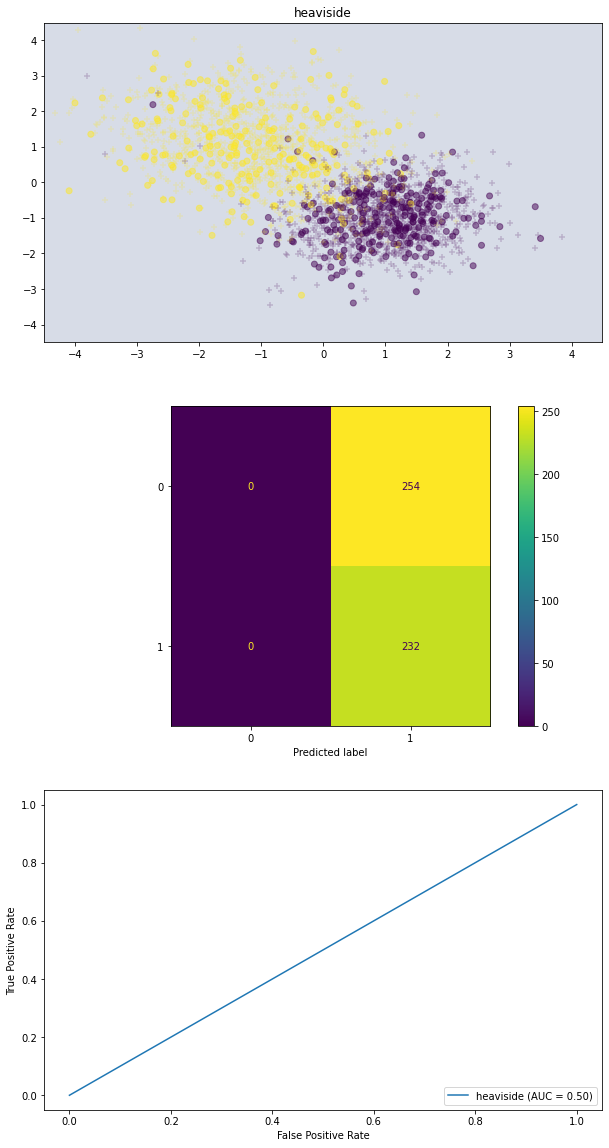

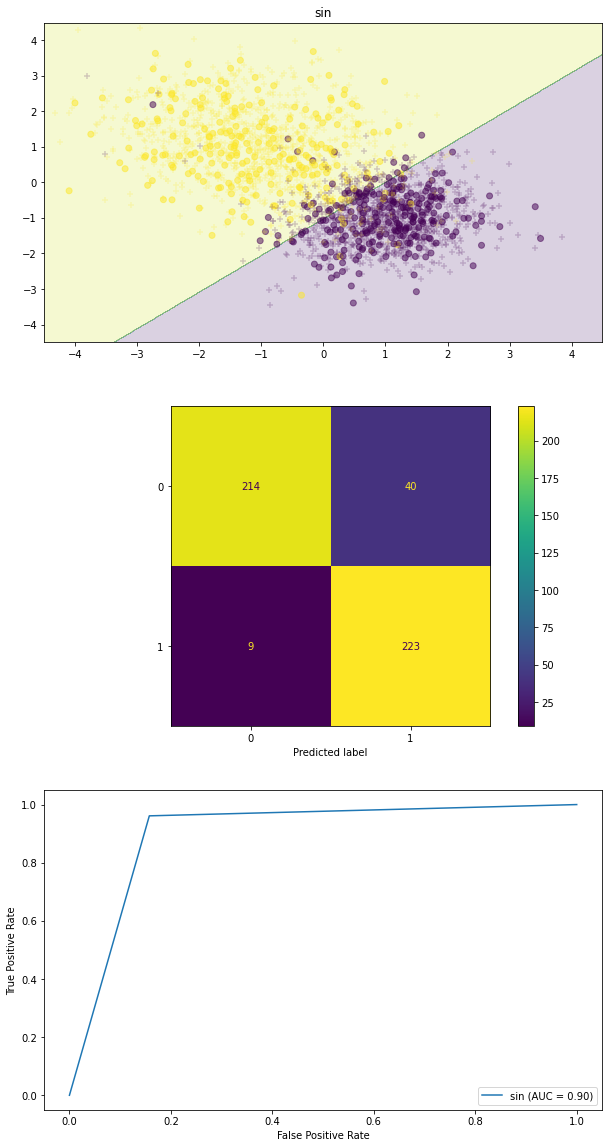

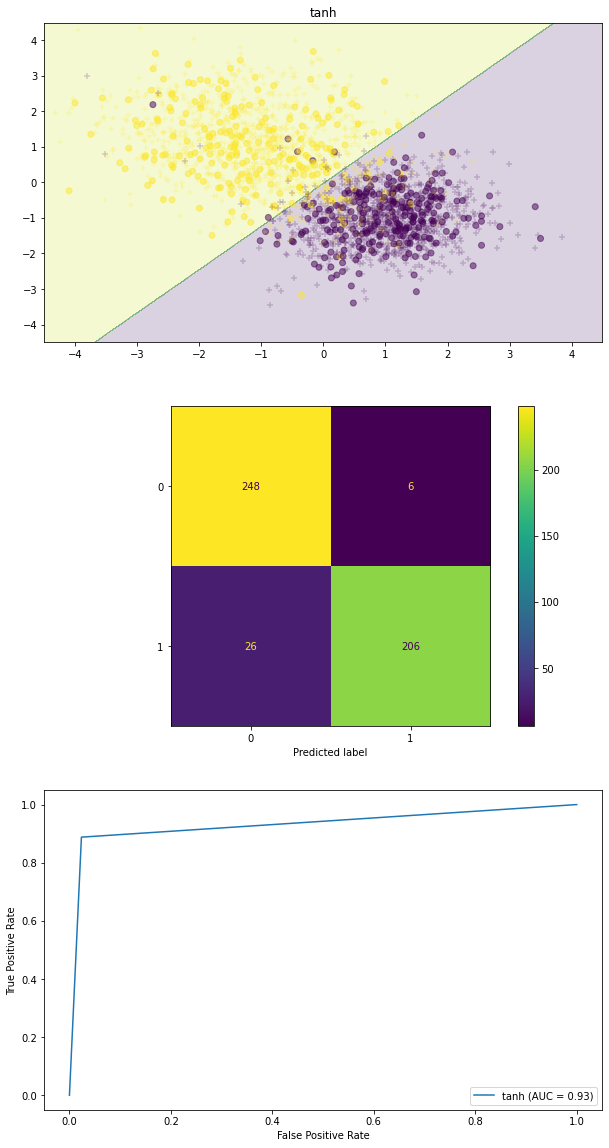

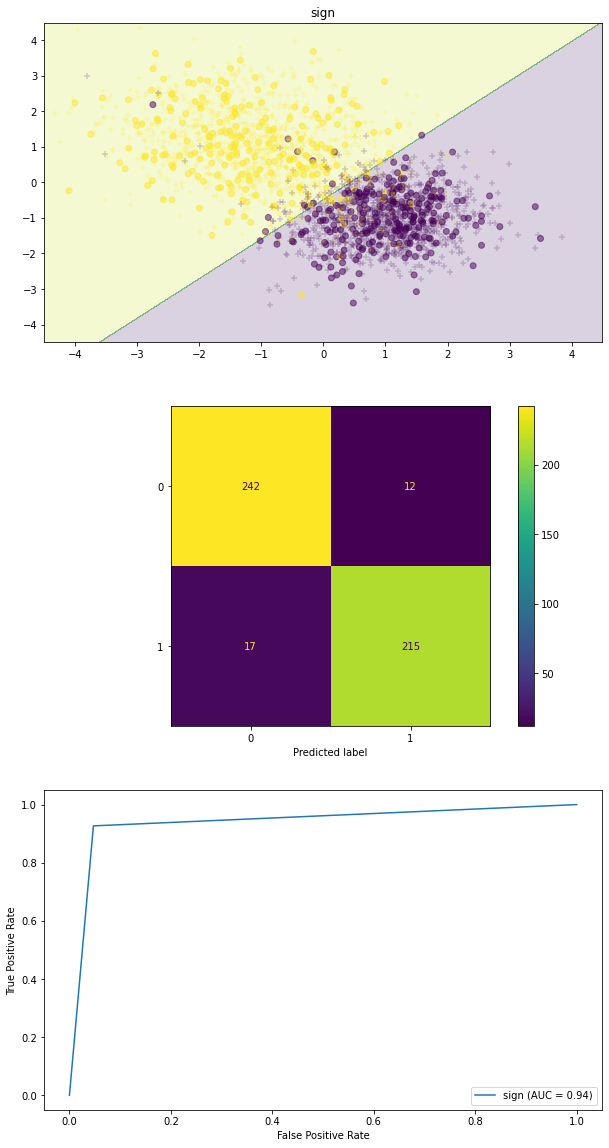

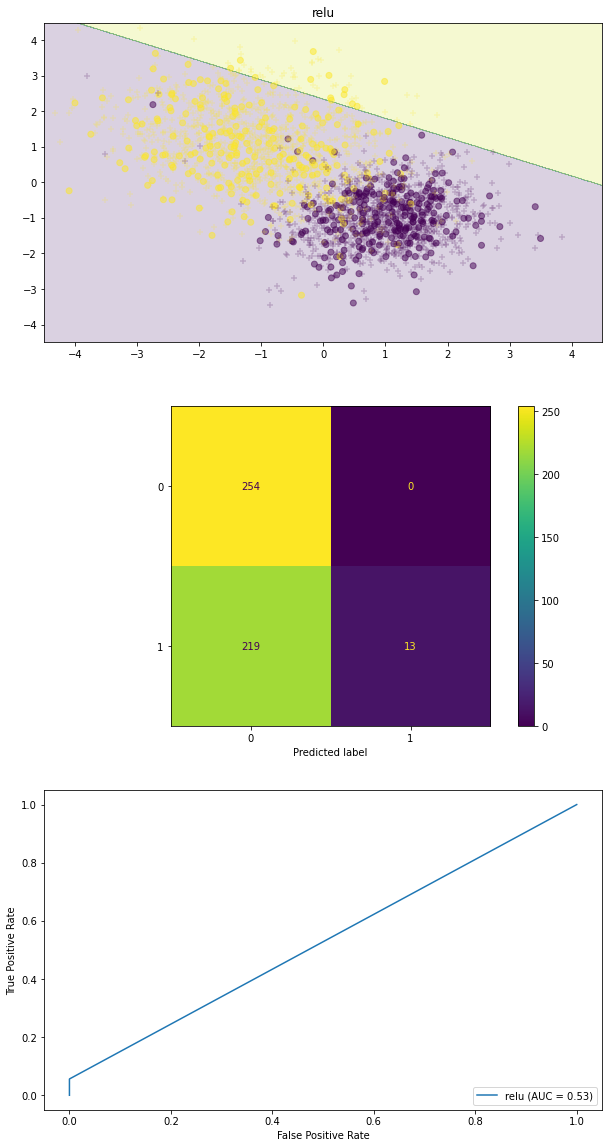

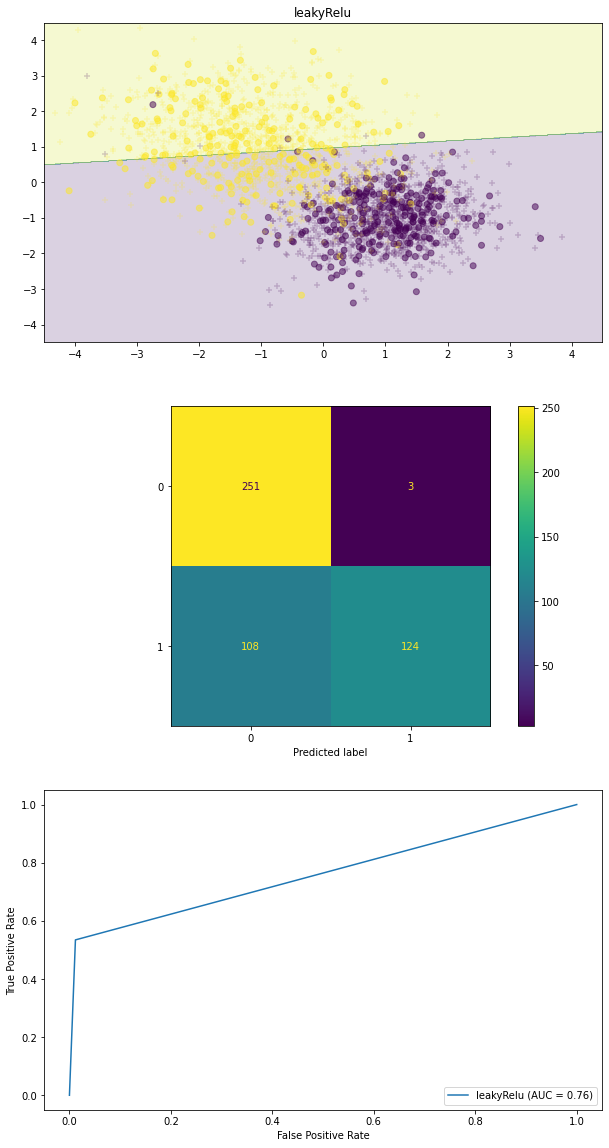

In [10]:
for activationF in lst:    
    model = myNeuron(activation = activationF)
    visualization(model ,X_train, X_test, y_train, y_test, activation=activationF)

C:\Users\Bartek\AppData\Local\Temp\ipykernel_3852\3666139380.py:49: RuntimeWarning: invalid value encountered in longlong_scalars
  my_sens = my_cm[0][0]/(my_cm[0][0]+my_cm[1][0])


                  | heaviside  
Czułość           |      nan
Swoistość         |   1.0000
Accuracy          |   0.4774
Czas wykonania    | 5.52E+00
                  | sin  
Czułość           |   0.5234
Swoistość         |   0.5372
Accuracy          |   0.4979
Czas wykonania    | 5.20E+00
                  | tanh  
Czułość           |   0.5330
Swoistość         |   0.5101
Accuracy          |   0.5082
Czas wykonania    | 4.26E+00
                  | sign  
Czułość           |   0.5336
Swoistość         |   0.4280
Accuracy          |   0.5144
Czas wykonania    | 4.10E+00
                  | relu  
Czułość           |   0.5248
Swoistość         |   0.1587
Accuracy          |   0.5185
Czas wykonania    | 4.15E+00
                  | leakyRelu  
Czułość           |   0.5127
Swoistość         |   0.2448
Accuracy          |   0.4959
Czas wykonania    | 4.20E+00


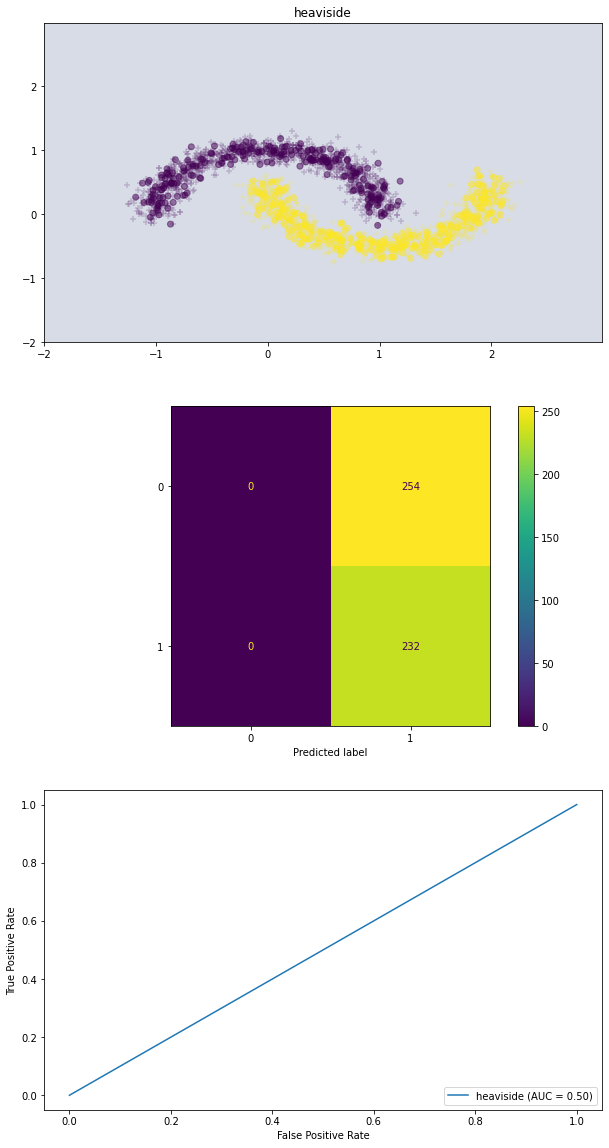

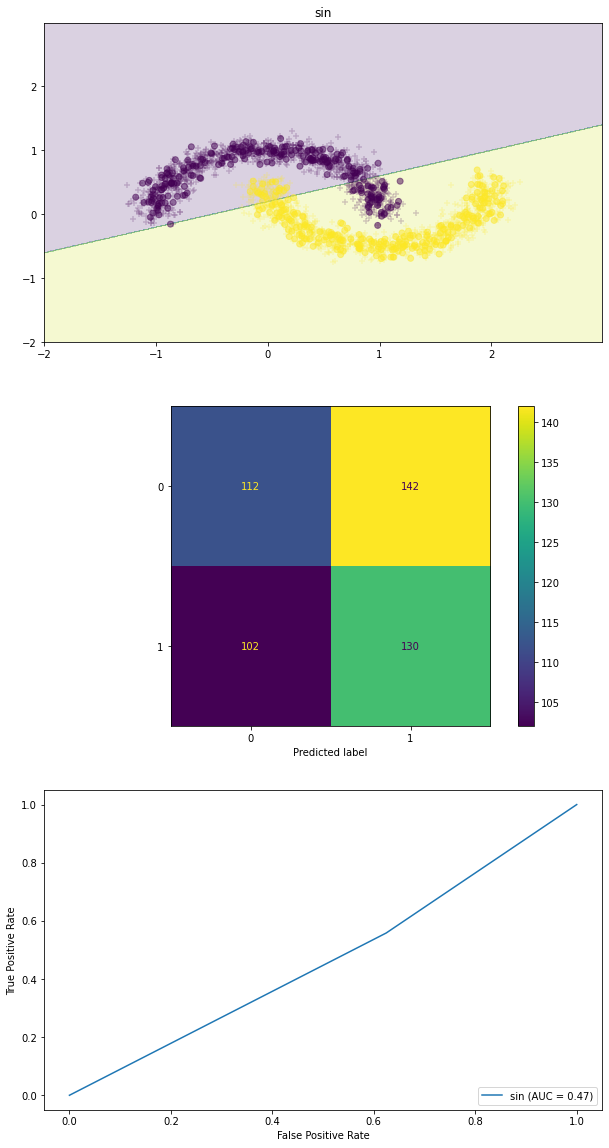

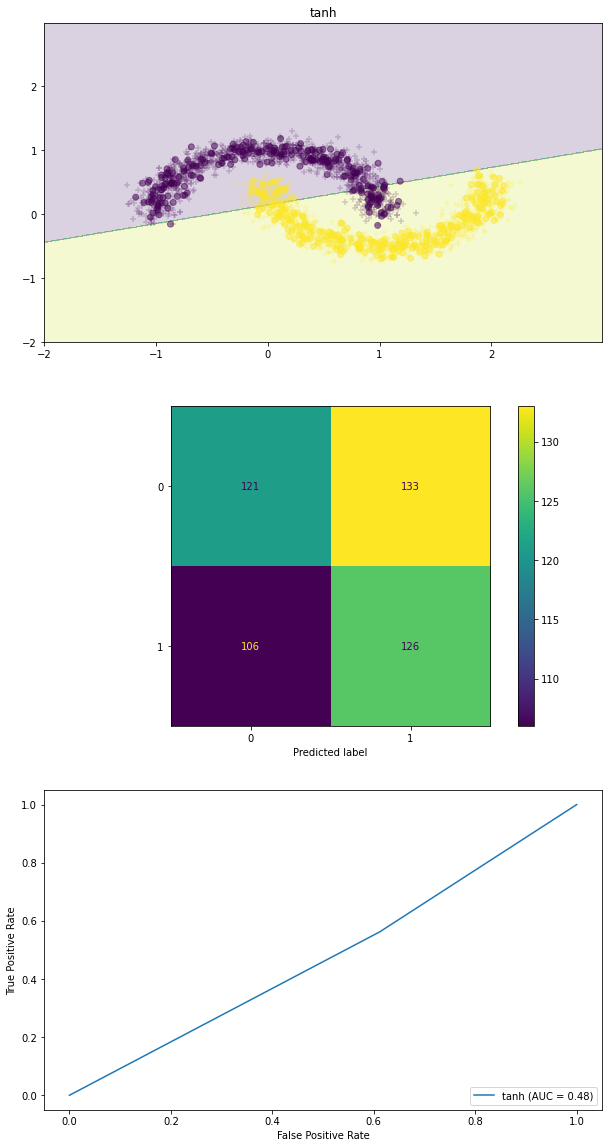

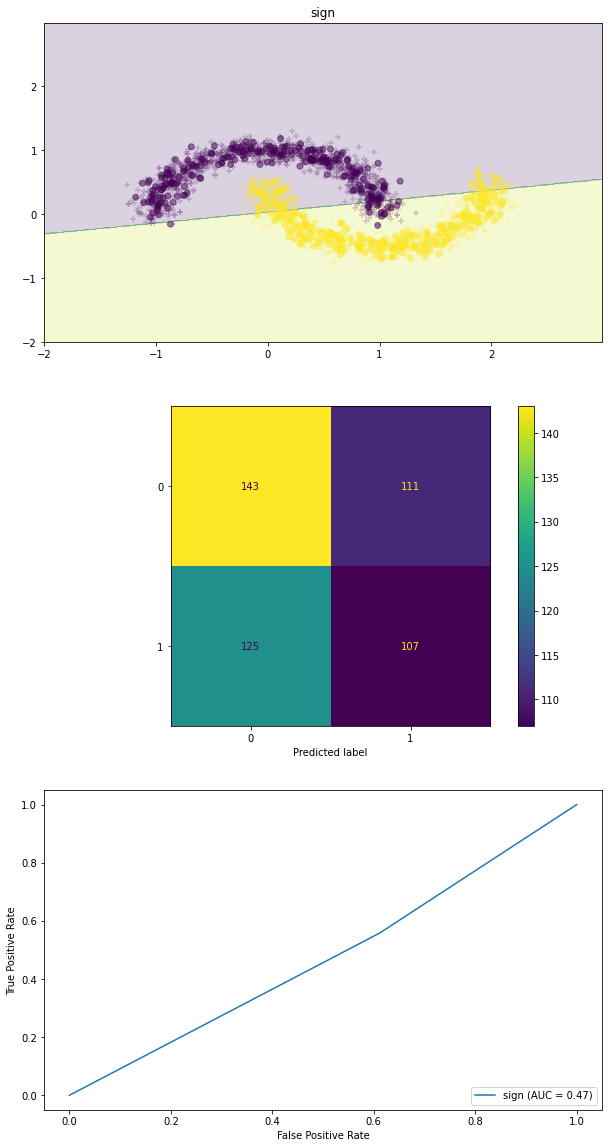

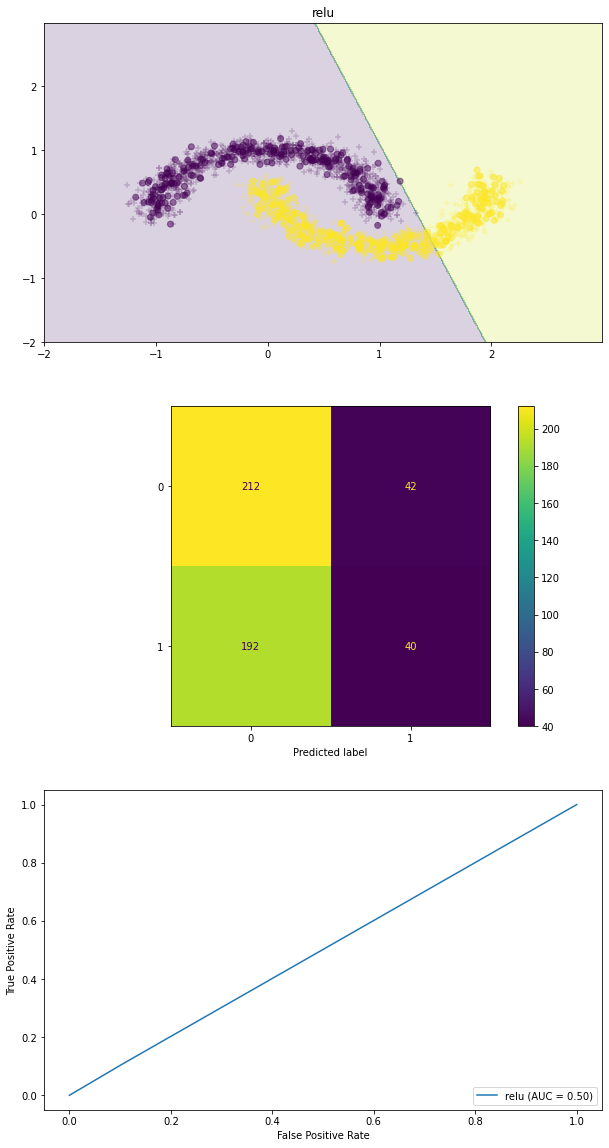

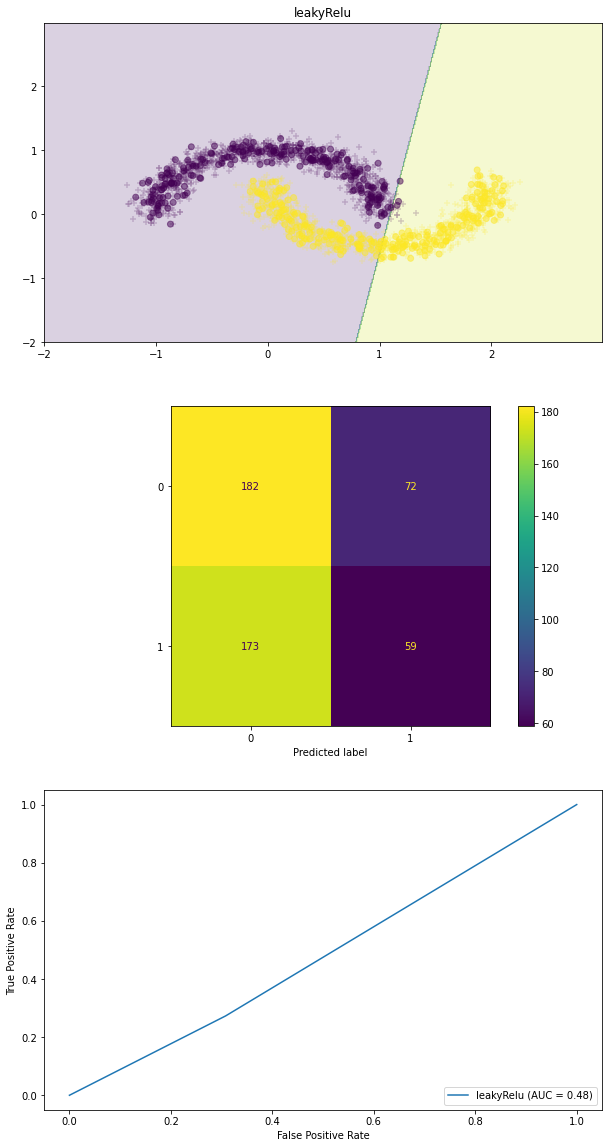

In [11]:
for activationF in lst:    
    model = myNeuron(activation = activationF)
    visualization(model, M_train, M_test, mc_train, mc_test, activation=activationF,roc=False)